# Stroke prediction

In [1]:
# import of neccesary modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import Series, DataFrame
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

,ID,Gender,Age_In_Days,Hypertension,Heart_Disease,Ever_Married,Type_Of_Work,Residence,Avg_Glucose,BMI,Smoking_Status,Stroke
0,31153,Male,1104.0,0,0,No,children,Rural,95.12,18.0,NaN,0
1,30650,Male,21204.0,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0
2,17412,Female,2928.0,0,0,No,Private,Urban,110.89,17.6,NaN,0
3,57008,Female,25578.0,0,0,Yes,Private,Rural,69.04,35.9,formerly smoked,0
4,46657,Male,5128.0,0,0,No,Never_worked,Rural,161.28,19.1,NaN,0


,ID,Age_In_Days,Hypertension,Heart_Disease,Avg_Glucose,BMI,Stroke
count,43400.000000,43400.000000,43400.000000,43400.000000,43400.000000,41938.000000,43400.000000
mean,36875.482604,15446.234931,0.093571,0.047512,104.482750,28.605038,0.018041
std,21072.890037,8334.882942,0.291235,0.212733,43.111751,7.770020,0.133103
min,176.000000,-16381.000000,0.000000,0.000000,55.000000,10.100000,0.000000
25%,18594.250000,8789.000000,0.000000,0.000000,77.540000,23.200000,0.000000
50%,36908.000000,16074.000000,0.000000,0.000000,91.580000,27.700000,0.000000
75%,55054.250000,21923.250000,0.000000,0.000000,112.070000,32.900000,0.000000
max,73899.000000,264301.000000,1.000000,1.000000,291.050000,97.600000,1.000000


missing values in % : 

 Smoking_Status    30.63
BMI                3.37
Stroke             0.00
Avg_Glucose        0.00
Residence          0.00
Type_Of_Work       0.00
Ever_Married       0.00
Heart_Disease      0.00
Hypertension       0.00
Age_In_Days        0.00
Gender             0.00
ID                 0.00
dtype: float64


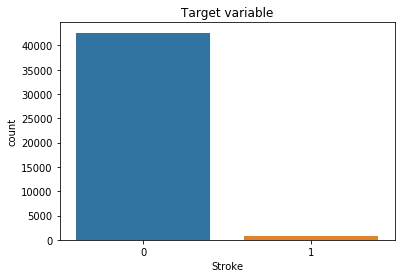

In [2]:
# first look at the data
df = pd.read_csv(r'Stroke_Prediction.csv')
display(df.head())
# display(df.dtypes)
# number of missing values
display(df.describe())

def missing(df):
    print ('missing values in % : \n\n', round((df.isnull().sum() * 100/ len(df)),2).sort_values(ascending=False))

missing(df)
# plot storke - no stroke proportion
plt.title('Target variable')
ax = sns.countplot(x="Stroke", data=df)

##  filling missing data and removing outliers

In [3]:
# fill missing values for BMI with median value       
df['BMI'].fillna(np.median, inplace =True)
df['BMI'] = pd.to_numeric(df['BMI'], errors='coerce')

# classify BMI into obese (0) and not obese (1)
series = df['BMI'] 
df['obese'] = [0 if x <=35 else 1 for x in series]

# remove outliers - age more tha 100 years old
df = df.loc[df['Age_In_Days'] < 40000]
df = df.loc[df['Age_In_Days'] > 0]

df['Age_years'] = df['Age_In_Days']/365

df['Smoking_Status'].fillna('never smoked', inplace =True)
# remove ramaining null values
df = df.dropna()
missing(df)

missing values in % : 

 Age_years         0.0
obese             0.0
Stroke            0.0
Smoking_Status    0.0
BMI               0.0
Avg_Glucose       0.0
Residence         0.0
Type_Of_Work      0.0
Ever_Married      0.0
Heart_Disease     0.0
Hypertension      0.0
Age_In_Days       0.0
Gender            0.0
ID                0.0
dtype: float64


## Explanatory analysis of variables

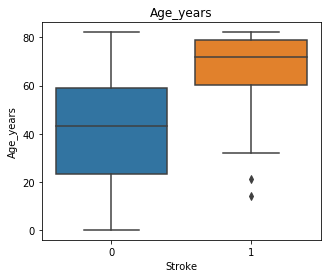

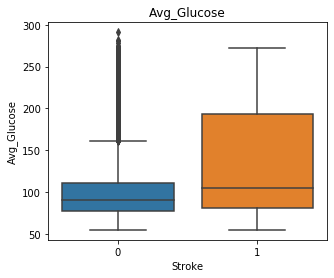

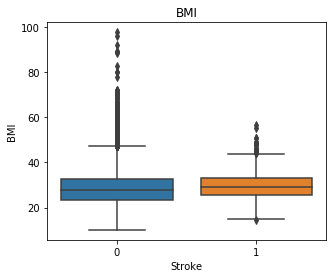

In [4]:
lista_numeric = ['Age_years', 'Avg_Glucose', 'BMI']

for i in lista_numeric:
    plt.figure(figsize=(5, 4))
    plt.title(i)
    ax = sns.boxplot(x="Stroke", y=i, data=df)

<Figure size 720x288 with 0 Axes>

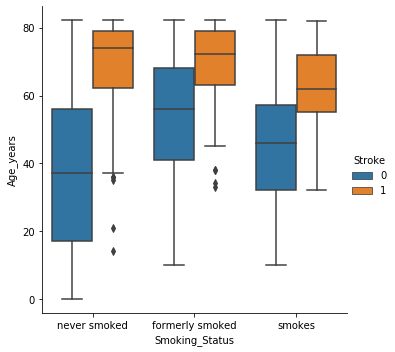

<Figure size 720x288 with 0 Axes>

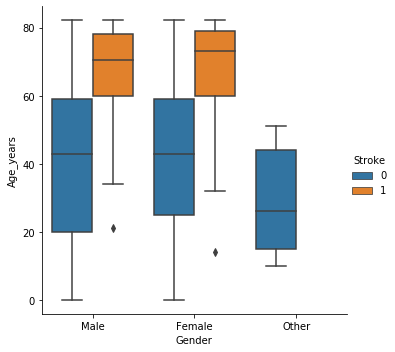

<Figure size 720x288 with 0 Axes>

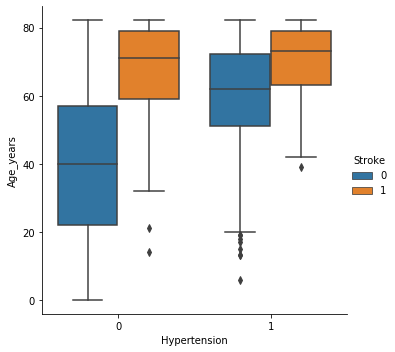

<Figure size 720x288 with 0 Axes>

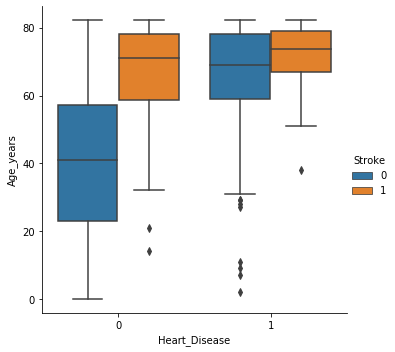

<Figure size 720x288 with 0 Axes>

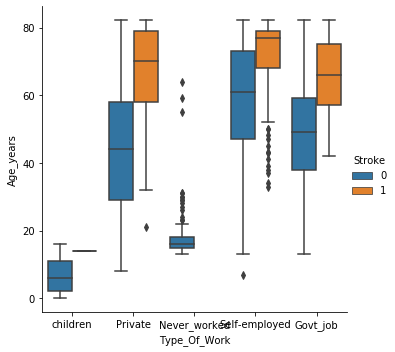

<Figure size 720x288 with 0 Axes>

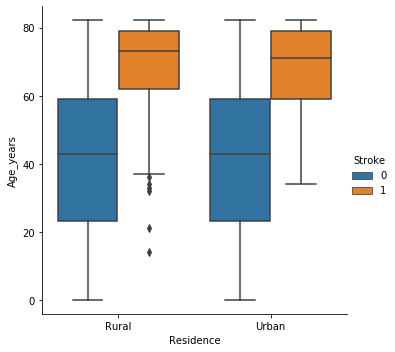

In [5]:
lista_cat = ["Smoking_Status","Gender", "Hypertension","Heart_Disease","Type_Of_Work","Residence"]

for i in lista_cat: 
    plt.figure(figsize=(10, 4))
    sns.catplot(x=i, y="Age_years", hue="Stroke", kind="box", data=df)

### Recode categorical variables

In [6]:
# 0: male, 1:female
series = df['Gender']
df['Gender'] = [0 if x == 'Male' else 1 for x in series]
series = df['Ever_Married']

df['Ever_Married'] = [0 if x == 'No' else 1 for x in series]
series = df['Residence']

# 0: rural, 1: urban
df['Residence'] = [0 if x == 'Rural' else 1 for x in series]

# Predictions

In [7]:
# Function for classification with diffrent ML methods

def modeling(X_train_res, X_test, y_train_res, y_test, df, model, name, variables):
    
    # Setup the pipeline steps: scaling and fitting model 
    steps = [('scaler', StandardScaler()),
                         ('reg', model)]
    
    # Create the pipeline: pipeline
    pipeline = Pipeline(steps)

    # Fit it to the training data
    pipeline.fit(X_train_res, y_train_res)

    # Predict the labels of the test set: y_pred
    y_pred = pipeline.predict(X_test)

    # Compute and print AUC score
    auc_roc = roc_auc_score(y_test, y_pred)
    print("AUC: {}, model : {}".format(auc_roc, name))

    # Generate ROC curve values: fpr, tpr, thresholds
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    
    conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
    print('Confusion matrix:\n', conf_mat)

    labels = ['No Stroke', 'Stroke']
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.title('CM  ' +  name)
    plt.xlabel('Predicted')
    plt.ylabel('Expected')
    plt.show()

## selection of explanatory variables

In [11]:
variables_short = ['Age_In_Days', 'Heart_Disease', 'Avg_Glucose', 'BMI']

## spliting into train-test and upsampling of minority class

In [12]:
from imblearn.over_sampling import SMOTE 
sm = SMOTE(random_state = 2) 

X_train, X_test, y_train, y_test = train_test_split(df[variables_short], df['Stroke'], test_size=0.3)
    
## Up-sample Minority Class of stroke using SMOTE algorithm
X_train_res, y_train_res = sm.fit_sample(X_train, y_train) 

##  logistic regression

AUC: 0.7852927589790969, model : logistic regression
Confusion matrix:
 [[9002 3368]
 [  33  177]]


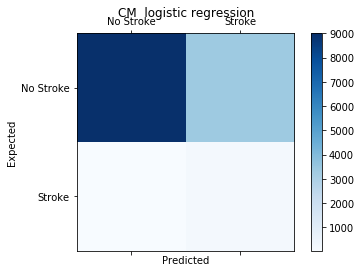

In [13]:
grid={"C":np.logspace(-3,3,7), "penalty":["l2"]} # l2 ridge
logreg=LogisticRegression()
logreg_cv=GridSearchCV(logreg, grid, scoring='roc_auc',cv=10)

modeling(X_train_res, X_test, y_train_res, y_test, df, logreg_cv, 'logistic regression', variables_short)

##  K - neighbours

AUC: 0.6415944874311892, model : K-neighbours
Confusion matrix:
 [[10336  2034]
 [  116    94]]


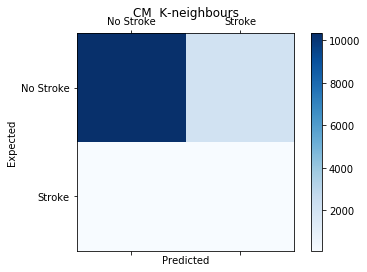

In [14]:
from sklearn.neighbors import KNeighborsClassifier
k_range = list(range(1, 31))

knn = KNeighborsClassifier()
param_grid = dict(n_neighbors=k_range)
NN_cv = GridSearchCV(knn, param_grid, cv=20, scoring='accuracy')

modeling(X_train_res, X_test, y_train_res, y_test, df, NN_cv, 'K-neighbours', variables_short)

## Decision Trees

AUC: 0.5595796281325788, model : Decision Trees
Confusion matrix:
 [[11370  1000]
 [  168    42]]


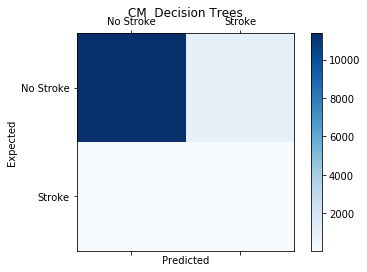

In [15]:
criterion = ['gini', 'entropy']
max_depth = [1, 2,4,6,8,12,18]

# Create a dictionary of all the parameter options 
parameters = dict(decisiontree__criterion=criterion,  decisiontree__max_depth=max_depth)

dec_trees_random = DecisionTreeClassifier(random_state=0)

clf = GridSearchCV(dec_trees_random, parameters)
modeling(X_train_res, X_test, y_train_res, y_test, df, dec_trees_random, 'Decision Trees', variables_short)

##  Support Vector Machines

In [ ]:
from sklearn.svm import SVC
from sklearn import svm
param_grid = {'C': [0.1,1], 'gamma': [0.1,0.01],'kernel': ['rbf']}

SVM_CV = SVC()

modeling(X_train_res, X_test, y_train_res, y_test, df, SVM_CV, 'SVM', variables_short)